In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore')

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pd.read_csv(datasets_path / 'deposits.csv', sep=";")

In [2]:
#Modifiche dataset per renderlo più leggibile

df = pd.DataFrame(data)
df['Data'] = pd.to_datetime(df['created_at'])
df = df.rename(columns={'waste_category_id': 'Categoria rifiuti'})

df=pd.DataFrame(df,columns=["ecoisola_id","Categoria rifiuti","Data"])

df.loc[df['Categoria rifiuti'] == 1, 'Categoria rifiuti'] = 'CARTA'
df.loc[df['Categoria rifiuti'] == 2, 'Categoria rifiuti'] = 'ORGANICO'
df.loc[df['Categoria rifiuti'] == 3, 'Categoria rifiuti'] = 'PLASTICA LATTINE'
df.loc[df['Categoria rifiuti'] == 4, 'Categoria rifiuti'] = 'SECCO RESIDUO'
df.loc[df['Categoria rifiuti'] == 5, 'Categoria rifiuti'] = 'VETRO'

In [3]:
df.head()

,ecoisola_id,Categoria rifiuti,Data
0,9,CARTA,2021-12-30 10:55:33
1,7,SECCO RESIDUO,2022-01-04 17:44:00
2,14,ORGANICO,2021-12-30 11:00:13
3,1,PLASTICA LATTINE,2021-12-30 11:00:48
4,24,CARTA,2021-12-30 11:01:57


## Conteggi

In [5]:
print("Conteggio rifiuti per categoria")
count_total = df['Categoria rifiuti'].value_counts()
print(count_total)


Conteggio rifiuti per categoria
PLASTICA LATTINE    194511
ORGANICO            137017
CARTA               114704
SECCO RESIDUO       108607
VETRO                42468
Name: Categoria rifiuti, dtype: int64


In [6]:
count_by_year = df.groupby([pd.Grouper(key='Data', freq='Y'), 'ecoisola_id', 'Categoria rifiuti']).size().reset_index(name='Conteggio')

print("Conteggio Annuale\n",count_by_year)

Conteggio Annuale
           Data  ecoisola_id Categoria rifiuti  Conteggio
0   2021-12-31            1             CARTA        694
1   2021-12-31            1          ORGANICO       1082
2   2021-12-31            1  PLASTICA LATTINE        971
3   2021-12-31            1     SECCO RESIDUO        631
4   2021-12-31            1             VETRO        220
..         ...          ...               ...        ...
266 2023-12-31           28  PLASTICA LATTINE       2171
267 2023-12-31           29  PLASTICA LATTINE       2743
268 2023-12-31           31          ORGANICO         95
269 2023-12-31           32          ORGANICO         29
270 2023-12-31           33          ORGANICO        107

[271 rows x 4 columns]


In [7]:
count_by_month = df.groupby([pd.Grouper(key='Data', freq='M'), 'ecoisola_id', 'Categoria rifiuti']).size().reset_index(name='Conteggio')

print("Conteggio Mensile\n",count_by_month)

Conteggio Mensile
            Data  ecoisola_id Categoria rifiuti  Conteggio
0    2021-10-31            1             CARTA        232
1    2021-10-31            1          ORGANICO        321
2    2021-10-31            1  PLASTICA LATTINE        320
3    2021-10-31            1     SECCO RESIDUO        193
4    2021-10-31            1             VETRO         55
...         ...          ...               ...        ...
1593 2023-03-31           28  PLASTICA LATTINE        274
1594 2023-03-31           29  PLASTICA LATTINE        383
1595 2023-03-31           31          ORGANICO         47
1596 2023-03-31           32          ORGANICO         14
1597 2023-03-31           33          ORGANICO         33

[1598 rows x 4 columns]


In [8]:
count_by_day = df.groupby([pd.Grouper(key='Data', freq='D'), 'ecoisola_id', 'Categoria rifiuti']).size().reset_index(name='Conteggio')

print("Conteggio Mensile\n",count_by_day)

Conteggio Mensile
             Data  ecoisola_id Categoria rifiuti  Conteggio
0     2021-10-05            1             CARTA          4
1     2021-10-05            1          ORGANICO          4
2     2021-10-05            1  PLASTICA LATTINE          3
3     2021-10-05            2             CARTA          7
4     2021-10-05            2          ORGANICO         13
...          ...          ...               ...        ...
44755 2023-03-09           15     SECCO RESIDUO          1
44756 2023-03-09           28  PLASTICA LATTINE         13
44757 2023-03-09           29  PLASTICA LATTINE         23
44758 2023-03-09           31          ORGANICO          4
44759 2023-03-09           33          ORGANICO          1

[44760 rows x 4 columns]


In [9]:
count_by_hour = df.groupby([pd.Grouper(key='Data', freq='H'), 'ecoisola_id', 'Categoria rifiuti']).size().reset_index(name='Conteggio')

print("Conteggio Mensile\n",count_by_hour)

Conteggio Mensile
                       Data  ecoisola_id Categoria rifiuti  Conteggio
0      2021-10-05 02:00:00           21  PLASTICA LATTINE          1
1      2021-10-05 04:00:00           24             CARTA          1
2      2021-10-05 05:00:00            9          ORGANICO          1
3      2021-10-05 05:00:00           18             CARTA          1
4      2021-10-05 05:00:00           25  PLASTICA LATTINE          1
...                    ...          ...               ...        ...
336467 2023-03-09 10:00:00           14  PLASTICA LATTINE          2
336468 2023-03-09 10:00:00           14     SECCO RESIDUO          2
336469 2023-03-09 10:00:00           14             VETRO          2
336470 2023-03-09 10:00:00           29  PLASTICA LATTINE          4
336471 2023-03-09 10:00:00           31          ORGANICO          3

[336472 rows x 4 columns]


## Preprocessing

Aggiungiamo il riempimento del singolo cassonetto dell'isola ecologica in base alla seguente stima riguardo la percentuale di riempimento: Plastica 3% - Carta 2,5% - Secco 2,5% - Organico 2% - Vetro 2,7% la capacità di ogni cassonetto di ogni isola è di 1100kg

In [10]:
df_analisi=count_by_month

df_analisi.loc[df_analisi['Categoria rifiuti'] == "CARTA", 'Quantità Totale'] = df_analisi['Conteggio']*2.5
df_analisi.loc[df_analisi['Categoria rifiuti'] == 'ORGANICO', 'Quantità Totale'] = df_analisi['Conteggio']*2
df_analisi.loc[df_analisi['Categoria rifiuti'] == 'PLASTICA LATTINE', 'Quantità Totale'] = df_analisi['Conteggio']*3
df_analisi.loc[df_analisi['Categoria rifiuti'] == 'SECCO RESIDUO', 'Quantità Totale'] = df_analisi['Conteggio']*2.5
df_analisi.loc[df_analisi['Categoria rifiuti'] == 'VETRO', 'Quantità Totale'] = df_analisi['Conteggio']*2.7
#Aggiungo il numero del mese come 


df_analisi.head()

,Data,ecoisola_id,Categoria rifiuti,Conteggio,Quantità Totale
0,2021-10-31,1,CARTA,232,580.0
1,2021-10-31,1,ORGANICO,321,642.0
2,2021-10-31,1,PLASTICA LATTINE,320,960.0
3,2021-10-31,1,SECCO RESIDUO,193,482.5
4,2021-10-31,1,VETRO,55,148.5


In [11]:
df_analisi.isnull().sum()

Data                 0
ecoisola_id          0
Categoria rifiuti    0
Conteggio            0
Quantità Totale      0
dtype: int64

In [12]:
#Analisi per plastica
#df_analisi = df_analisi[df_analisi['Categoria rifiuti'] == 'PLASTICA LATTINE']

df_analisi = df_analisi.drop(['Conteggio'], axis=1) 
df_analisi['Mese'] = df_analisi['Data'].dt.month
df_analisi = df_analisi[df_analisi['Data'].dt.year == 2022]
#df_analisi['Ora'] = df_analisi['Data'].dt.hour

df_analisi.head()

,Data,ecoisola_id,Categoria rifiuti,Quantità Totale,Mese
259,2022-01-31,1,CARTA,487.5,1
260,2022-01-31,1,ORGANICO,628.0,1
261,2022-01-31,1,PLASTICA LATTINE,654.0,1
262,2022-01-31,1,SECCO RESIDUO,477.5,1
263,2022-01-31,1,VETRO,218.7,1


In [13]:
df_analisi['Ora'] = df_analisi['Data'].dt.hour
df_analisi

,Data,ecoisola_id,Categoria rifiuti,Quantità Totale,Mese,Ora
259,2022-01-31,1,CARTA,487.5,1,0
260,2022-01-31,1,ORGANICO,628.0,1,0
261,2022-01-31,1,PLASTICA LATTINE,654.0,1,0
262,2022-01-31,1,SECCO RESIDUO,477.5,1,0
263,2022-01-31,1,VETRO,218.7,1,0
...,...,...,...,...,...,...
1333,2022-12-31,26,CARTA,522.5,12,0
1334,2022-12-31,27,PLASTICA LATTINE,1617.0,12,0
1335,2022-12-31,28,PLASTICA LATTINE,3123.0,12,0
1336,2022-12-31,29,PLASTICA LATTINE,3600.0,12,0


In [14]:
df_base=df_analisi
df_estivi = df_base[(df_base['Mese'] >= 6) & (df_base['Mese'] <= 8)]
df_estivi.head()

,Data,ecoisola_id,Categoria rifiuti,Quantità Totale,Mese,Ora
702,2022-06-30,1,CARTA,617.5,6,0
703,2022-06-30,1,ORGANICO,730.0,6,0
704,2022-06-30,1,PLASTICA LATTINE,987.0,6,0
705,2022-06-30,1,SECCO RESIDUO,727.5,6,0
706,2022-06-30,1,VETRO,307.8,6,0


In [15]:
pivot_df = df_estivi.pivot_table(index=df_estivi.index, columns="Categoria rifiuti", values="Quantità Totale", aggfunc=np.mean)

# Rinomina delle colonne create
pivot_df.columns = [f"{col}" for col in pivot_df.columns]

# Aggiunta delle colonne create al DataFrame originale
df_estivi = pd.concat([df_estivi, pivot_df], axis=1)
df_est = df_estivi.groupby('ecoisola_id').agg({'CARTA': 'sum','ORGANICO': 'sum','PLASTICA LATTINE':'sum','SECCO RESIDUO':'sum','VETRO':'sum'}).reset_index()


df_est.head()

,ecoisola_id,CARTA,ORGANICO,PLASTICA LATTINE,SECCO RESIDUO,VETRO
0,1,2342.5,2946.0,4167.0,2867.5,1247.4
1,2,6985.0,6512.0,13299.0,11207.5,7538.4
2,3,3397.5,5352.0,6963.0,4630.0,2435.4
3,4,3525.0,3704.0,6459.0,4175.0,1995.3
4,5,2060.0,3452.0,3915.0,2810.0,1206.9


In [16]:
df_base=df_analisi
df_invernali = df_base[(df_base['Mese'] <= 5) | (df_base['Mese'] > 8)]
df_invernali.head()


,Data,ecoisola_id,Categoria rifiuti,Quantità Totale,Mese,Ora
259,2022-01-31,1,CARTA,487.5,1,0
260,2022-01-31,1,ORGANICO,628.0,1,0
261,2022-01-31,1,PLASTICA LATTINE,654.0,1,0
262,2022-01-31,1,SECCO RESIDUO,477.5,1,0
263,2022-01-31,1,VETRO,218.7,1,0


In [17]:
pivot_df = df_invernali.pivot_table(index=df_invernali.index, columns="Categoria rifiuti", values="Quantità Totale", aggfunc=np.mean)

# Rinomina delle colonne create
pivot_df.columns = [f"{col}" for col in pivot_df.columns]

# Aggiunta delle colonne create al DataFrame originale
df_invernali = pd.concat([df_invernali, pivot_df], axis=1)
df_inv = df_invernali.groupby('ecoisola_id').agg({'CARTA': 'sum','ORGANICO': 'sum','PLASTICA LATTINE':'sum','SECCO RESIDUO':'sum','VETRO':'sum'}).reset_index()


df_inv.head()

,ecoisola_id,CARTA,ORGANICO,PLASTICA LATTINE,SECCO RESIDUO,VETRO
0,1,3895.0,5394.0,6207.0,4702.5,2000.7
1,2,4460.0,4332.0,7365.0,6730.0,4087.8
2,3,4750.0,6892.0,8682.0,6262.5,2691.9
3,4,3700.0,3806.0,6942.0,5147.5,2232.9
4,5,3827.5,5950.0,6156.0,4370.0,1919.7


In [18]:
df_full=df_base

pivot_df = df_full.pivot_table(index=df_full.index, columns="Categoria rifiuti", values="Quantità Totale", aggfunc=np.mean)

# Rinomina delle colonne create
pivot_df.columns = [f"{col}" for col in pivot_df.columns]

# Aggiunta delle colonne create al DataFrame originale
df_full = pd.concat([df_full, pivot_df], axis=1)
df_full = df_full.groupby('ecoisola_id').agg({'CARTA': 'sum','ORGANICO': 'sum','PLASTICA LATTINE':'sum','SECCO RESIDUO':'sum','VETRO':'sum'}).reset_index()

df_full.head()


,ecoisola_id,CARTA,ORGANICO,PLASTICA LATTINE,SECCO RESIDUO,VETRO
0,1,6237.5,8340.0,10374.0,7570.0,3248.1
1,2,11445.0,10844.0,20664.0,17937.5,11626.2
2,3,8147.5,12244.0,15645.0,10892.5,5127.3
3,4,7225.0,7510.0,13401.0,9322.5,4228.2
4,5,5887.5,9402.0,10071.0,7180.0,3126.6


## Analisi PCA sui mesi invernali

In [55]:
#Select dataset analysis
df_ecoisola=df_inv

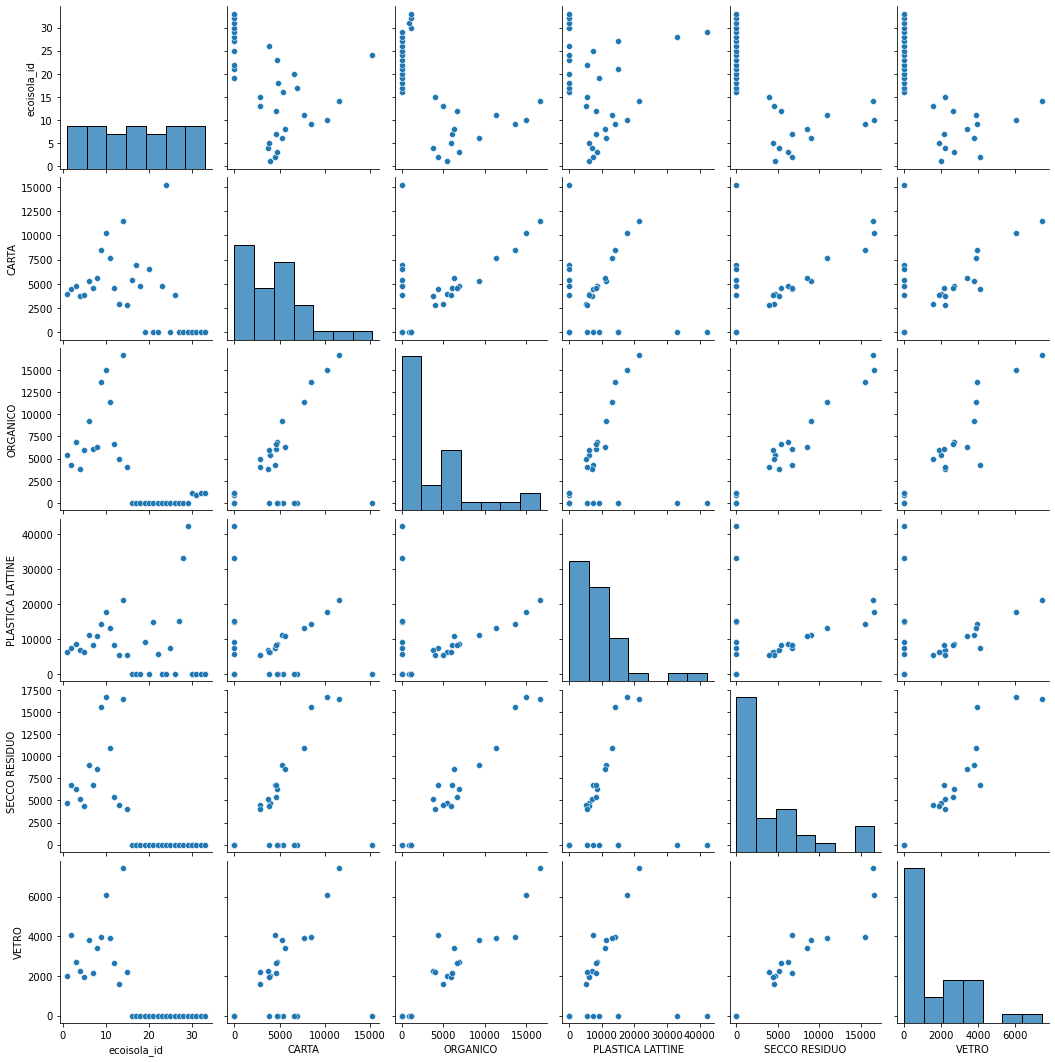

In [19]:
sns.pairplot(df_ecoisola)

<function matplotlib.pyplot.show(close=None, block=None)>

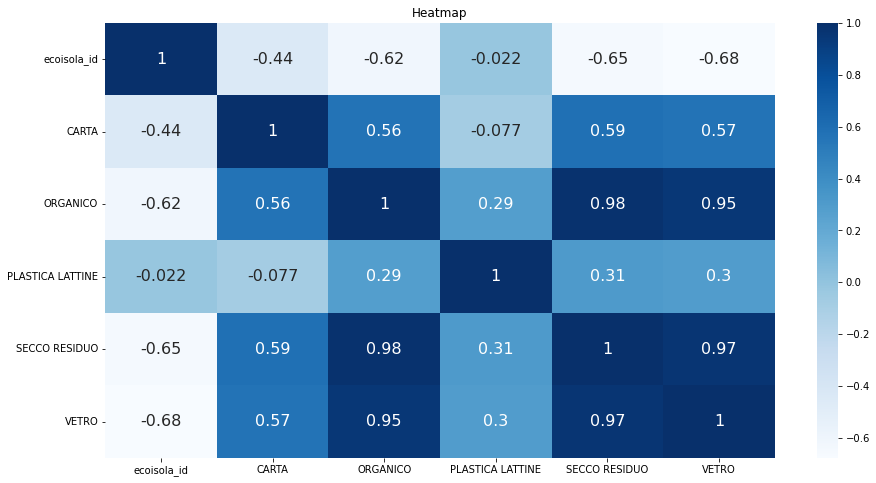

In [20]:
plt.figure(figsize=(15,8))
sns.heatmap(df_ecoisola.corr(), cmap='Blues', annot=True, annot_kws={"fontsize":16})
plt.title('Heatmap')
plt.show

In [56]:
dataframe=df_ecoisola.drop(["ecoisola_id"],axis=1)
#dataframe = df_ecoisola[(df_ecoisola['ecoisola_id'] <=15 )]
#dataframe=dataframe.drop(["ecoisola_id"],axis=1)

dataframe.head(20)

,CARTA,ORGANICO,PLASTICA LATTINE,SECCO RESIDUO,VETRO
0,3895.0,5394.0,6207.0,4702.5,2000.7
1,4460.0,4332.0,7365.0,6730.0,4087.8
2,4750.0,6892.0,8682.0,6262.5,2691.9
3,3700.0,3806.0,6942.0,5147.5,2232.9
4,3827.5,5950.0,6156.0,4370.0,1919.7
5,5297.5,9282.0,11250.0,9035.0,3812.4
6,4577.5,6090.0,8148.0,6737.5,2143.8
7,5577.5,6324.0,10980.0,8580.0,3415.5
8,8437.5,13678.0,14217.0,15557.5,3971.7
9,10260.0,14930.0,17820.0,16677.5,6069.6


[0.63489897 0.31519341 0.04591177 0.00253597 0.00145987]


Text(0, 0.5, 'Cumulative Explained Variance')

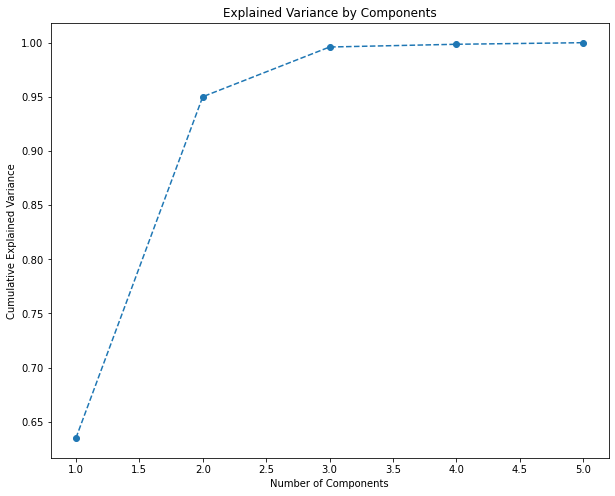

In [57]:
pca=PCA().fit(dataframe)

print(pca.explained_variance_ratio_)

plt.figure(figsize=(10,8))
plt.plot(range(1,6),pca.explained_variance_ratio_.cumsum(),marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Text(0, 0.5, 'wcss')

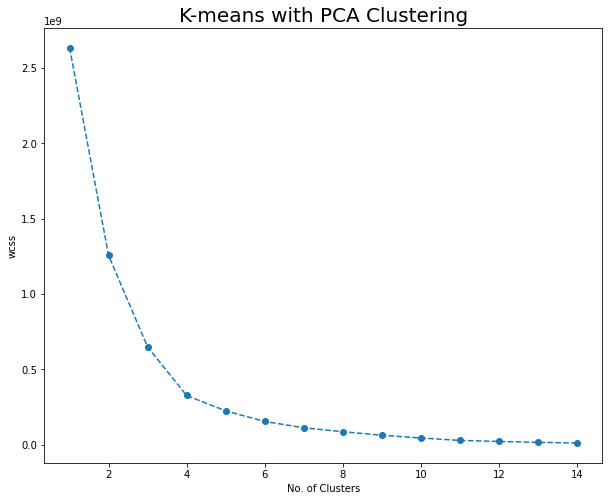

In [58]:
pca=PCA(n_components=2).fit(dataframe)
pca.transform(dataframe)
scores_pca=pca.transform(dataframe)

wcss= []
for i in range (2,16):
    km = KMeans(n_clusters=i, init='k-means++', random_state=21)
    km.fit(scores_pca)
    wcss.append(km.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,15),wcss, marker='o',linestyle='--')
plt.title('K-means with PCA Clustering', fontsize=20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')

In [59]:
#analisi risultati del clustering
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state=21)
kmeans_pca.fit(scores_pca)

df_segm_pca_kmeans=pd.concat([dataframe.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)
df_segm_pca_kmeans.columns.values[-2:]=['Component 1','Component 2']

df_segm_pca_kmeans['Segment K-means PCA']= kmeans_pca.labels_
df_segm_pca_kmeans['Segment']=df_segm_pca_kmeans['Segment K-means PCA'].map({0:'Solo Carta o Organico',1:'Mista Basso',2:'Solo Plastica Alto',3:'Solo Plastica Basso',4:'Mista Alto'})
df_segm_pca_kmeans.head()

,CARTA,ORGANICO,PLASTICA LATTINE,SECCO RESIDUO,VETRO,Component 1,Component 2,Segment K-means PCA,Segment
0,3895.0,5394.0,6207.0,4702.5,2000.7,-1307.730529,-2359.786926,1,Mista Basso
1,4460.0,4332.0,7365.0,6730.0,4087.8,313.530977,-3198.287474,1,Mista Basso
2,4750.0,6892.0,8682.0,6262.5,2691.9,1908.405682,-3625.644016,1,Mista Basso
3,3700.0,3806.0,6942.0,5147.5,2232.9,-904.311901,-1436.575657,1,Mista Basso
4,3827.5,5950.0,6156.0,4370.0,1919.7,-1317.701666,-2446.115091,1,Mista Basso


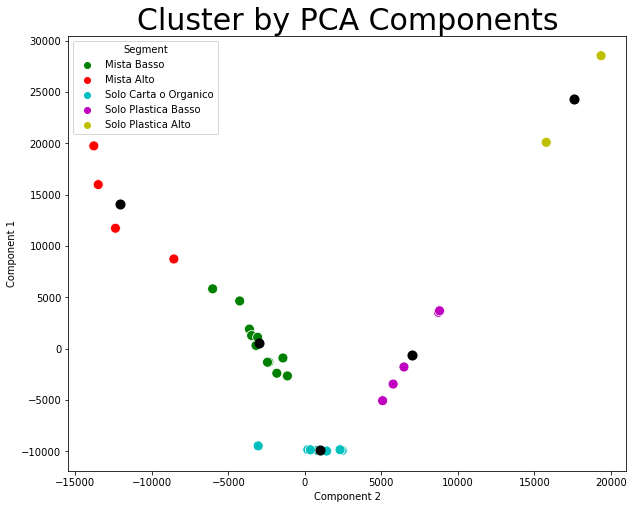

In [60]:
# Calcola i centroidi
centroids = df_segm_pca_kmeans.groupby('Segment').mean()

# Crea il grafico a dispersione con i cluster colorati
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize=(10, 8))
plt.title("Cluster by PCA Components", fontsize=30)
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['Segment'], palette=['g', 'r', 'c','m','y'], s=100)

# Aggiungi i centroidi al grafico
plt.scatter(centroids['Component 2'], centroids['Component 1'], marker='o', s=50, linewidths=3, color='black')

# Visualizza il grafico
plt.show()


## Analisi PCA sui mesi estivi

In [49]:
#Select dataset analysis
df_ecoisola=df_est

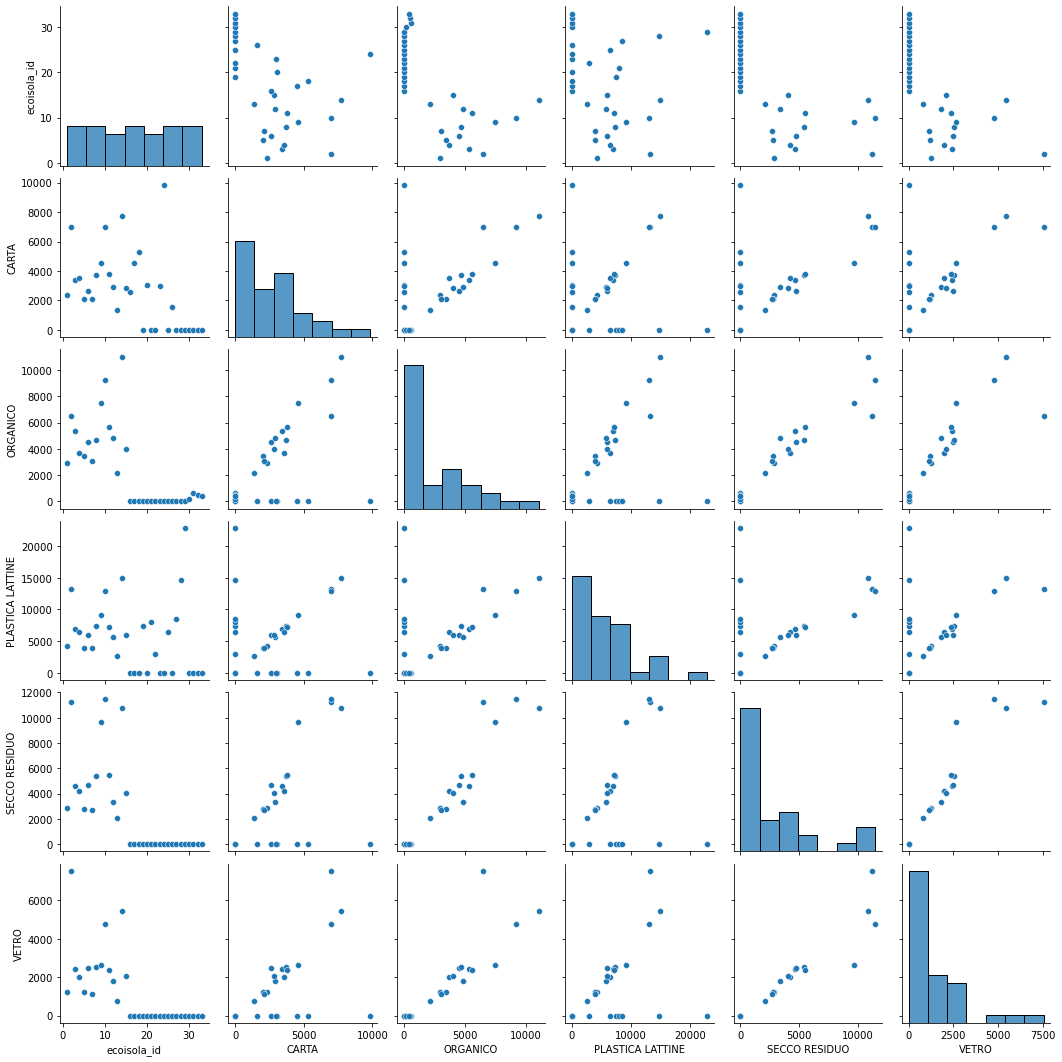

In [34]:
sns.pairplot(df_ecoisola)

<function matplotlib.pyplot.show(close=None, block=None)>

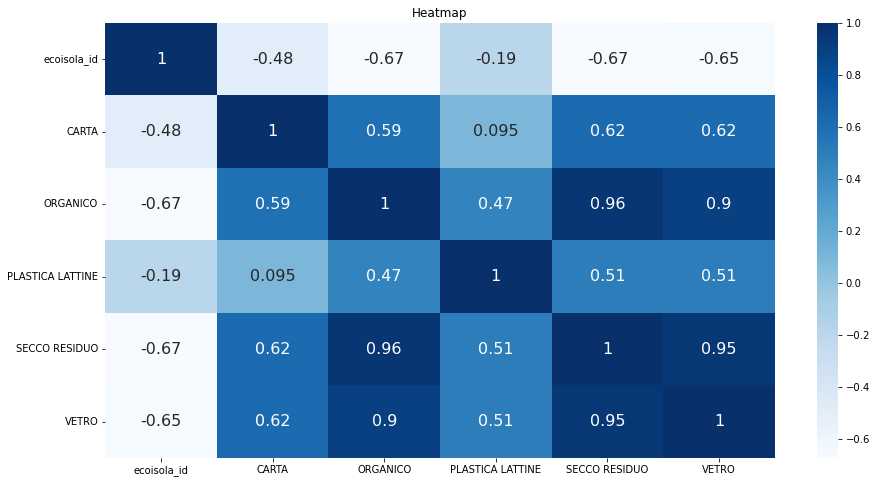

In [55]:
plt.figure(figsize=(15,8))
sns.heatmap(df_ecoisola.corr(), cmap='Blues', annot=True, annot_kws={"fontsize":16})
plt.title('Heatmap')
plt.show

In [50]:
dataframe=df_ecoisola.drop(["ecoisola_id","SECCO RESIDUO"],axis=1)
#dataframe = df_ecoisola[(df_ecoisola['ecoisola_id'] <=15 )]
#dataframe=dataframe.drop(["ecoisola_id"],axis=1)

dataframe.head()

,CARTA,ORGANICO,PLASTICA LATTINE,VETRO
0,2342.5,2946.0,4167.0,1247.4
1,6985.0,6512.0,13299.0,7538.4
2,3397.5,5352.0,6963.0,2435.4
3,3525.0,3704.0,6459.0,1995.3
4,2060.0,3452.0,3915.0,1206.9


[0.70119762 0.23608733 0.05375698 0.00895807]


Text(0, 0.5, 'Cumulative Explained Variance')

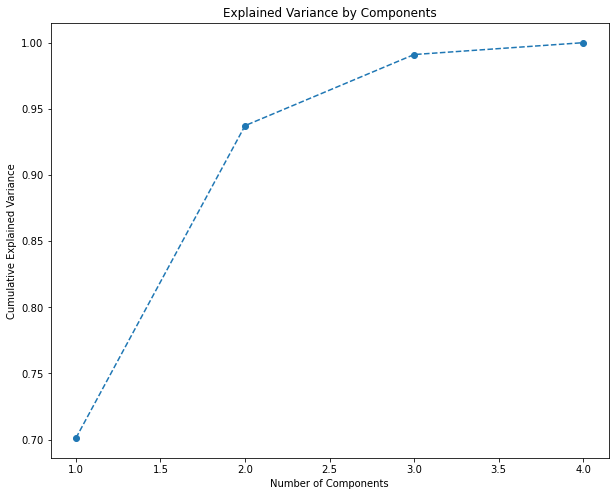

In [51]:
pca=PCA(svd_solver='full').fit(dataframe)

print(pca.explained_variance_ratio_)

plt.figure(figsize=(10,8))
plt.plot(range(1,5),pca.explained_variance_ratio_.cumsum(),marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Text(0, 0.5, 'wcss')

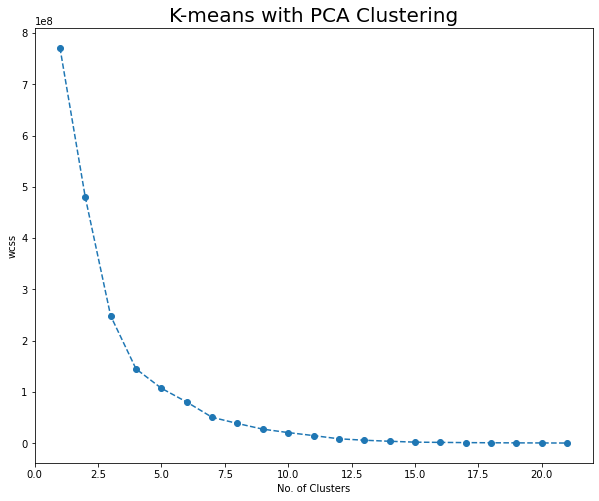

In [52]:
pca=PCA(n_components=2).fit(dataframe)
pca.transform(dataframe)
scores_pca=pca.transform(dataframe)

wcss= []
for i in range (2,23):
    km = KMeans(n_clusters=i, init='k-means++', random_state=13)
    km.fit(scores_pca)
    wcss.append(km.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,22),wcss, marker='o',linestyle='--')
plt.title('K-means with PCA Clustering', fontsize=20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')

In [53]:
#analisi risultati del clustering
kmeans_pca = KMeans(n_clusters=6, init='k-means++', random_state=13)
kmeans_pca.fit(scores_pca)

df_segm_pca_kmeans=pd.concat([dataframe.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)
df_segm_pca_kmeans.columns.values[-2:]=['Component 1','Component 2']

df_segm_pca_kmeans['Segment K-means PCA']= kmeans_pca.labels_
df_segm_pca_kmeans['Segment']=df_segm_pca_kmeans['Segment K-means PCA'].map({0:'Misto Basso',5:'Misto Medio',2:'Misto Alto',4:'Solo Plastica Medio',1:'Solo Plastica Alto',3:'Solo Carta o Organico'})

df_segm_pca_kmeans.head()

,CARTA,ORGANICO,PLASTICA LATTINE,VETRO,Component 1,Component 2,Segment K-means PCA,Segment
0,2342.5,2946.0,4167.0,1247.4,-1056.664533,-646.193547,0,Misto Basso
1,6985.0,6512.0,13299.0,7538.4,10340.624781,-4223.049322,2,Misto Alto
2,3397.5,5352.0,6963.0,2435.4,2683.915803,-2052.775851,5,Misto Medio
3,3525.0,3704.0,6459.0,1995.3,1583.609390,-1196.509377,5,Misto Medio
4,2060.0,3452.0,3915.0,1206.9,-1154.314994,-856.661638,0,Misto Basso


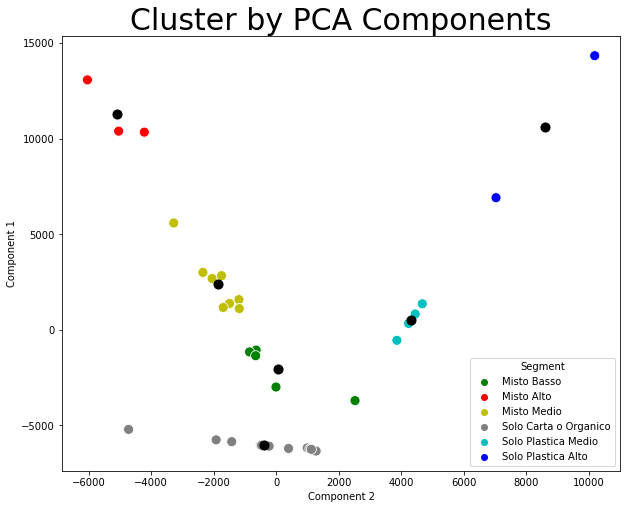

In [54]:
# Calcola i centroidi
centroids = df_segm_pca_kmeans.groupby('Segment').mean()

# Crea il grafico a dispersione con i cluster colorati
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize=(10, 8))
plt.title("Cluster by PCA Components", fontsize=30)
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['Segment'], palette=['g', 'r', 'y','gray','c','b'], s=100)

# Aggiungi i centroidi al grafico
plt.scatter(centroids['Component 2'], centroids['Component 1'], marker='o', s=50, linewidths=3, color='black', label='Centroide')

# Visualizza il grafico
plt.show()


## Full dataset

In [42]:
df_ecoisola=df_full

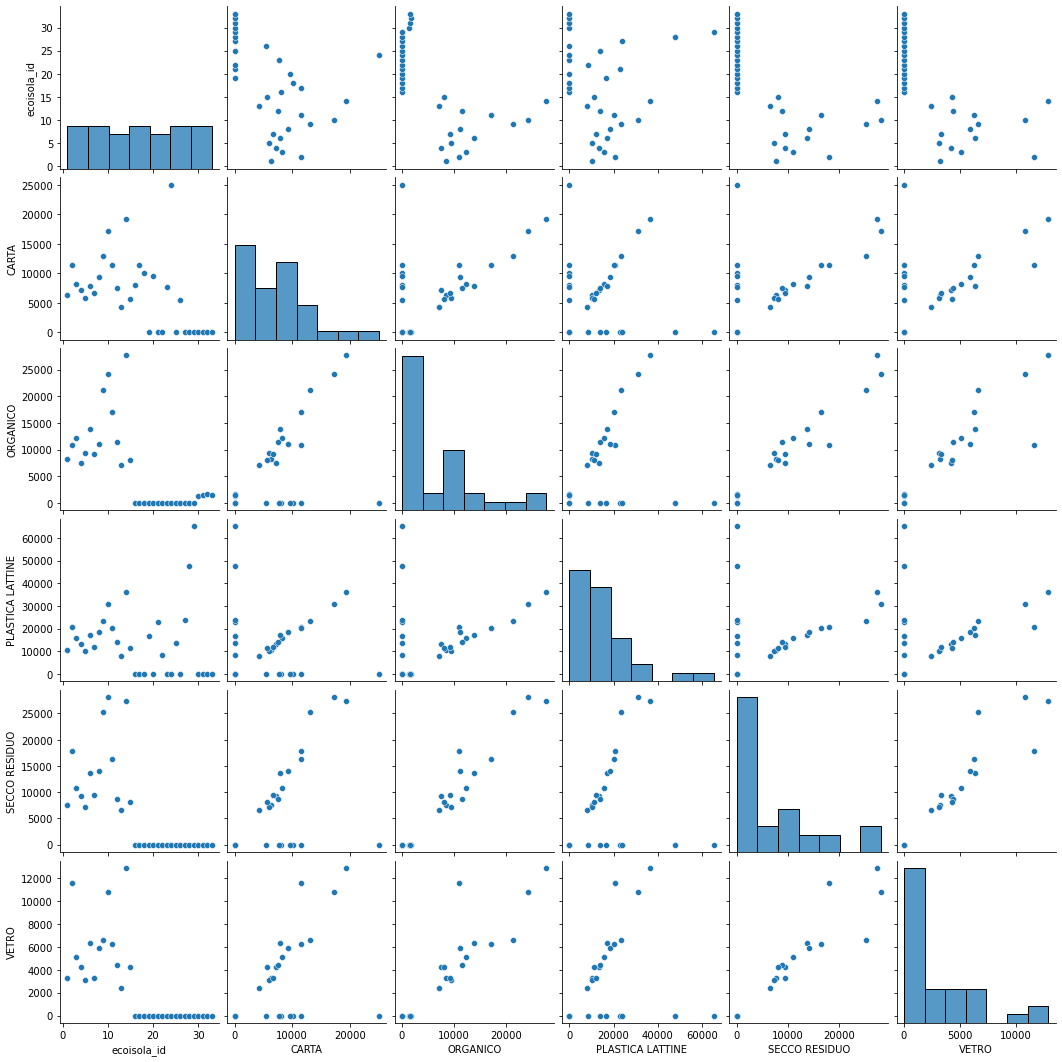

In [43]:
sns.pairplot(df_ecoisola)


<function matplotlib.pyplot.show(close=None, block=None)>

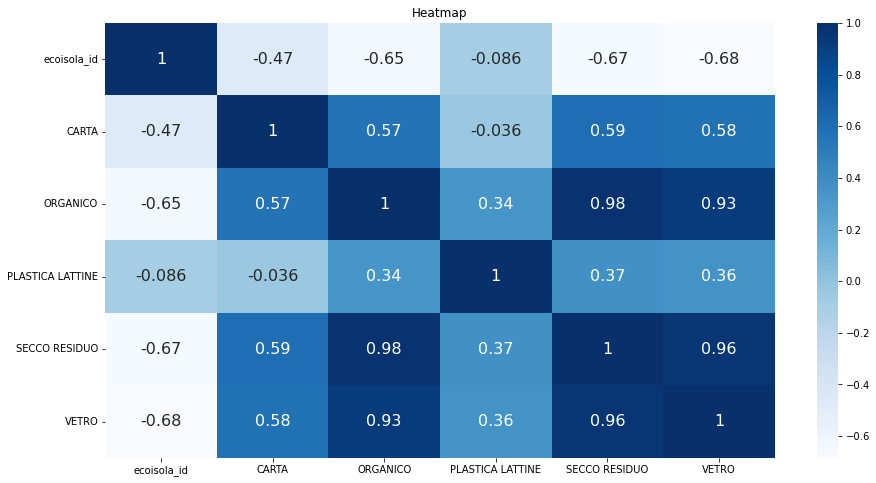

In [68]:
plt.figure(figsize=(15,8))
sns.heatmap(df_ecoisola.corr(), cmap='Blues', annot=True, annot_kws={"fontsize":16})
plt.title('Heatmap')
plt.show

In [44]:
dataframe=df_ecoisola.drop(["ecoisola_id"],axis=1)
#dataframe = df_ecoisola[(df_ecoisola['ecoisola_id'] <=15 )]
#dataframe=dataframe.drop(["ecoisola_id"],axis=1)

dataframe.head()

,CARTA,ORGANICO,PLASTICA LATTINE,SECCO RESIDUO,VETRO
0,6237.5,8340.0,10374.0,7570.0,3248.1
1,11445.0,10844.0,20664.0,17937.5,11626.2
2,8147.5,12244.0,15645.0,10892.5,5127.3
3,7225.0,7510.0,13401.0,9322.5,4228.2
4,5887.5,9402.0,10071.0,7180.0,3126.6


[0.63796924 0.3078704  0.04768284 0.0045347  0.00194282]


Text(0, 0.5, 'Cumulative Explained Variance')

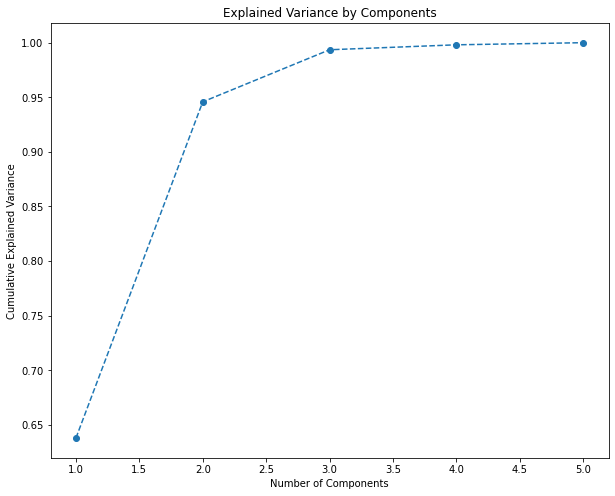

In [45]:
pca=PCA().fit(dataframe)

print(pca.explained_variance_ratio_)

plt.figure(figsize=(10,8))
plt.plot(range(1,6),pca.explained_variance_ratio_.cumsum(),marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

Text(0, 0.5, 'wcss')

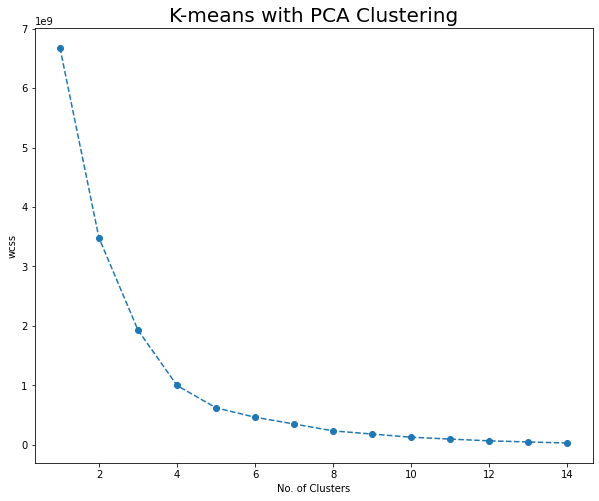

In [46]:
pca=PCA(n_components=2).fit(dataframe)
pca.transform(dataframe)
scores_pca=pca.transform(dataframe)

wcss= []
for i in range (2,16):
    km = KMeans(n_clusters=i, init='k-means++', random_state=21)
    km.fit(scores_pca)
    wcss.append(km.inertia_)

plt.figure(figsize=(10,8))
plt.plot(range(1,15),wcss, marker='o',linestyle='--')
plt.title('K-means with PCA Clustering', fontsize=20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')

In [47]:
#analisi risultati del clustering
kmeans_pca = KMeans(n_clusters=5, init='k-means++', random_state=21)
kmeans_pca.fit(scores_pca)

df_segm_pca_kmeans=pd.concat([dataframe.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)
df_segm_pca_kmeans.columns.values[-2:]=['Component 1','Component 2']

df_segm_pca_kmeans['Segment K-means PCA']= kmeans_pca.labels_
df_segm_pca_kmeans['Segment']=df_segm_pca_kmeans['Segment K-means PCA'].map({0:'Misto Alto',1:'Misto Basso',2:'Non Rilevanti',3:'Plastica Alto',4:'Plastica Basso'})
df_segm_pca_kmeans.head()

,CARTA,ORGANICO,PLASTICA LATTINE,SECCO RESIDUO,VETRO,Component 1,Component 2,Segment K-means PCA,Segment
0,6237.5,8340.0,10374.0,7570.0,3248.1,-1872.129108,-3436.289988,1,Misto Basso
1,11445.0,10844.0,20664.0,17937.5,11626.2,13298.266647,-9088.084133,1,Misto Basso
2,8147.5,12244.0,15645.0,10892.5,5127.3,5568.363163,-5703.946747,1,Misto Basso
3,7225.0,7510.0,13401.0,9322.5,4228.2,1330.621061,-3073.676244,1,Misto Basso
4,5887.5,9402.0,10071.0,7180.0,3126.6,-1983.012806,-3732.542597,1,Misto Basso


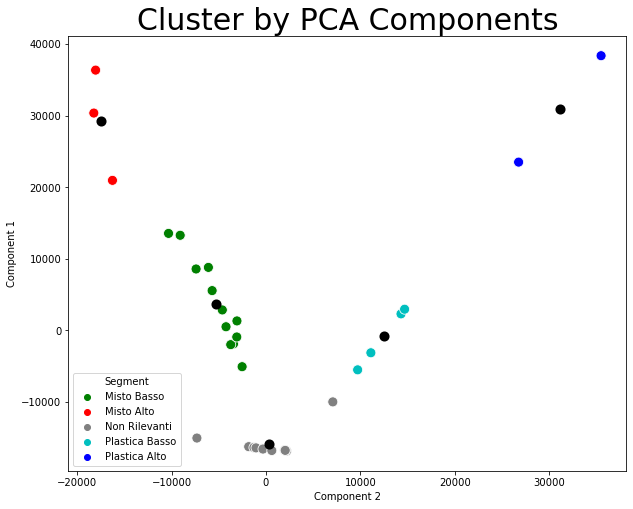

In [48]:
# Calcola i centroidi
centroids = df_segm_pca_kmeans.groupby('Segment').mean()

# Crea il grafico a dispersione con i cluster colorati
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize=(10, 8))
plt.title("Cluster by PCA Components", fontsize=30)
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['Segment'], palette=['g', 'r', 'gray','c','b'], s=100)

# Aggiungi i centroidi al grafico
plt.scatter(centroids['Component 2'], centroids['Component 1'], marker='o', s=50, linewidths=3, color='black')

# Visualizza il grafico
plt.show()